## Image registration (Fourier based)

**Deadline**: Upload this notebook (rename it as 'TP-ImageregistrationFourier-YOUR-SURNAME.ipynb') to E-Campus before the deadline. Please check on E-Campus for the exact date.

**Goal**: The goal of this notebook is to implement the algorithms seen today for Fourier-based rigid image registration. We will focus only on translation and rotation. Please andwer the questions and complete the code where you see **XXXXXXXXXXXXXX**

Let's first download (or upload if you are using your own computer) the data.

In [16]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1slGiE3jssCrFft-2TbcsWHrst95DDShT',
  dest_path='./paris-satellite.jpg')

  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1MVIhPTMq-KjuawlwIVvS063UpAOQYvzo',
  dest_path='./Chess_Board.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
workingDir='./'  

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


and the needed libraries

In [17]:
import math
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize, rescale, warp_polar, warp, SimilarityTransform, rotate
from skimage.morphology import square, dilation


Please run the following algorithms using a satellite image of Paris and a figure of a chessboard.

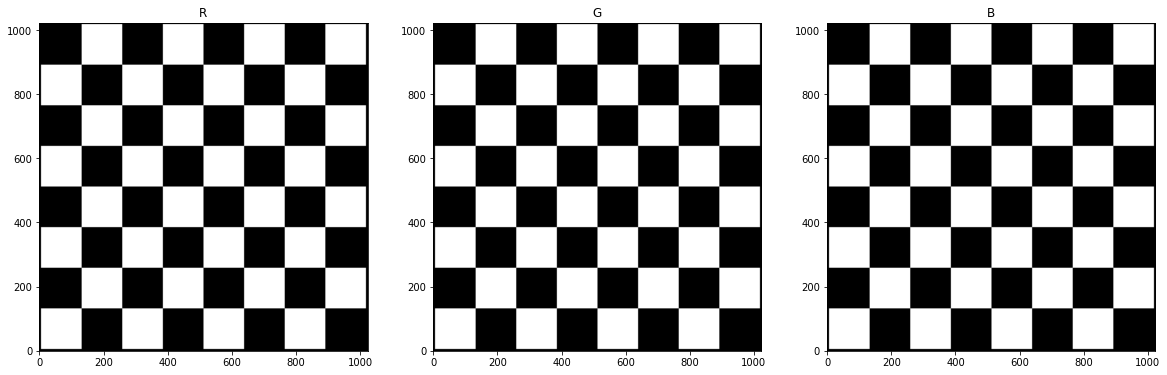

In [18]:
# img = imread(workingDir + 'paris-satellite.jpg')
img = imread(workingDir + 'Chess_Board.png')

#print(img.shape)

fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(img[:,:,0], cmap='gray')
ax1.invert_yaxis()
ax1.set_title('R')
ax2.imshow(img[:,:,1], cmap='gray')
ax2.invert_yaxis()
ax2.set_title('G')
ax3.imshow(img[:,:,2], cmap='gray')
ax3.invert_yaxis()
ax3.set_title('B')
plt.show() 


In order to compute the rotation and translation displacement between two images we first need to define a funtion which computes the phase correlation. Please complete the code 

Remember than in `numpy`:
*   to compute the FFT we use `np.fft.fft2`
*   to compute the inverse FFT we use `np.fft.ifft2`
*   to compute the complex conjugate you can use `np.conj`
*   to compute the magnitude of a Fourier transform $F$ you can use `np.sqrt(np.real(F)**2 + np.imag(F)**2)` or simply `np.abs`
*   Another important function maybe useful for later... `np.fft.fftshift`

In [19]:
def phaseCorrelation(X,Y):
  # Compute the fft of X
  fX = np.fft.fft2(X)
  if np.any(np.isnan(fX)) or np.any(np.isinf(fX)):
    print('problem ! There is a Nan and or Inf')
  # Compute the fft of the translated image Y
  fY = np.fft.fft2(Y)
  if np.any(np.isnan(fY)) or np.any(np.isinf(fY)):
    print('problem ! There is a Nan and or Inf')
  # Compute the complex conjugate  
  fYc=np.conj(fY)
  # Compute cross-power spectrum
  eps=1e-30 # in order not to divide by zero
  CPS=(np.multiply(fX,fYc))/(np.abs(np.multiply(fX,fYc))+eps)
  # compute the shift
  shift=np.fft.ifft2(CPS)
  # take only the real part (it should be a real delta...)
  realShift=np.real(shift)
  # delete small values (noise)
  realShift=(realShift == np.max(realShift))*1
  # look for the index corresponding to the maximum value
  ind = np.unravel_index(np.argmax(realShift), realShift.shape)
  # ind[0] corresponds to the row thus to the shift along the second axis (i.e. y-axis)
  # ind[1] corresponds to the column thus to the shift along the first axis (i.e. x-axis)
  return ind,realShift 


Let's first create a translated version of the original image with and without Gaussian noise. To simplify things we will just use one channel (a gray image). You can choose the channel you want. 

To deform the image, we will use the `warp` function of scikit-image. You will have to choose if you want a linear shift (`mode='constant'`) or a circular shift (`mode='wrap')

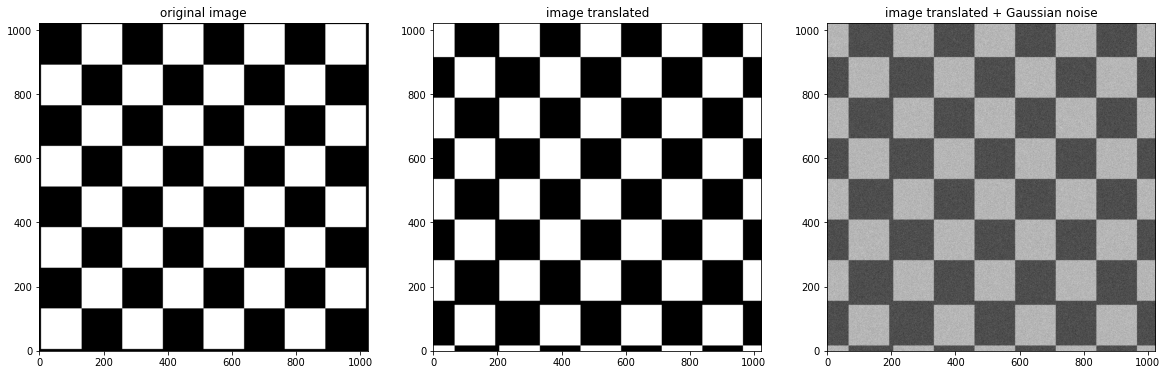

In [20]:
# Let's use only one channel
imgG=np.copy(img[:,:,0]) # red channel
a=200 # should be smaller than imgG.shape[0]
b=150 # should be smaller than imgG.shape[1]

# simple translation (the minus sign is to make it consistent with the lecture slides)
tformTranslation = SimilarityTransform(translation=(-a,-b)) 
# translated image
# mode='wrap' to have circuar shift or mode='constant' to have zero padding
# It works in both cases !! Even though we always assume a circuar shift transated image
imgGT = warp(imgG, tformTranslation, mode='wrap') 
# translated and noise image
imgGTN = imgGT + np.random.normal(0, 0.15, imgGT.shape)

fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(imgG, cmap='gray')
ax1.invert_yaxis()
ax1.set_title('original image')
ax2.imshow(imgGT, cmap='gray')
ax2.invert_yaxis()
ax2.set_title('image translated')
ax3.imshow(imgGTN, cmap='gray')
ax3.invert_yaxis()
ax3.set_title('image translated + Gaussian noise')
plt.show() 

Let's try to find the translation parameters using the phase Correlation method.

Remember that when assuming a circular shift, as it is case here, a negative displacement $a$ is equivalent to a positive displacement $N+a$ where we also assume that $a<N$. Same things for $b$.

Furthermore, we assume that we don't know whether the image has been created using a circular or a linear shift. You will have to test it and find the correct warp mode !

Question: How would you find the correct image ? Implement your idea.

# Translate image

Expected a is: 200
Estimated a is: 200 using a circular shift this is equivalent to: -824
Expected b is: 150
Estimated b is: 150 using a circular shift this is equivalent to: -874
The right combination is : a=200, b=150, mode=wrap


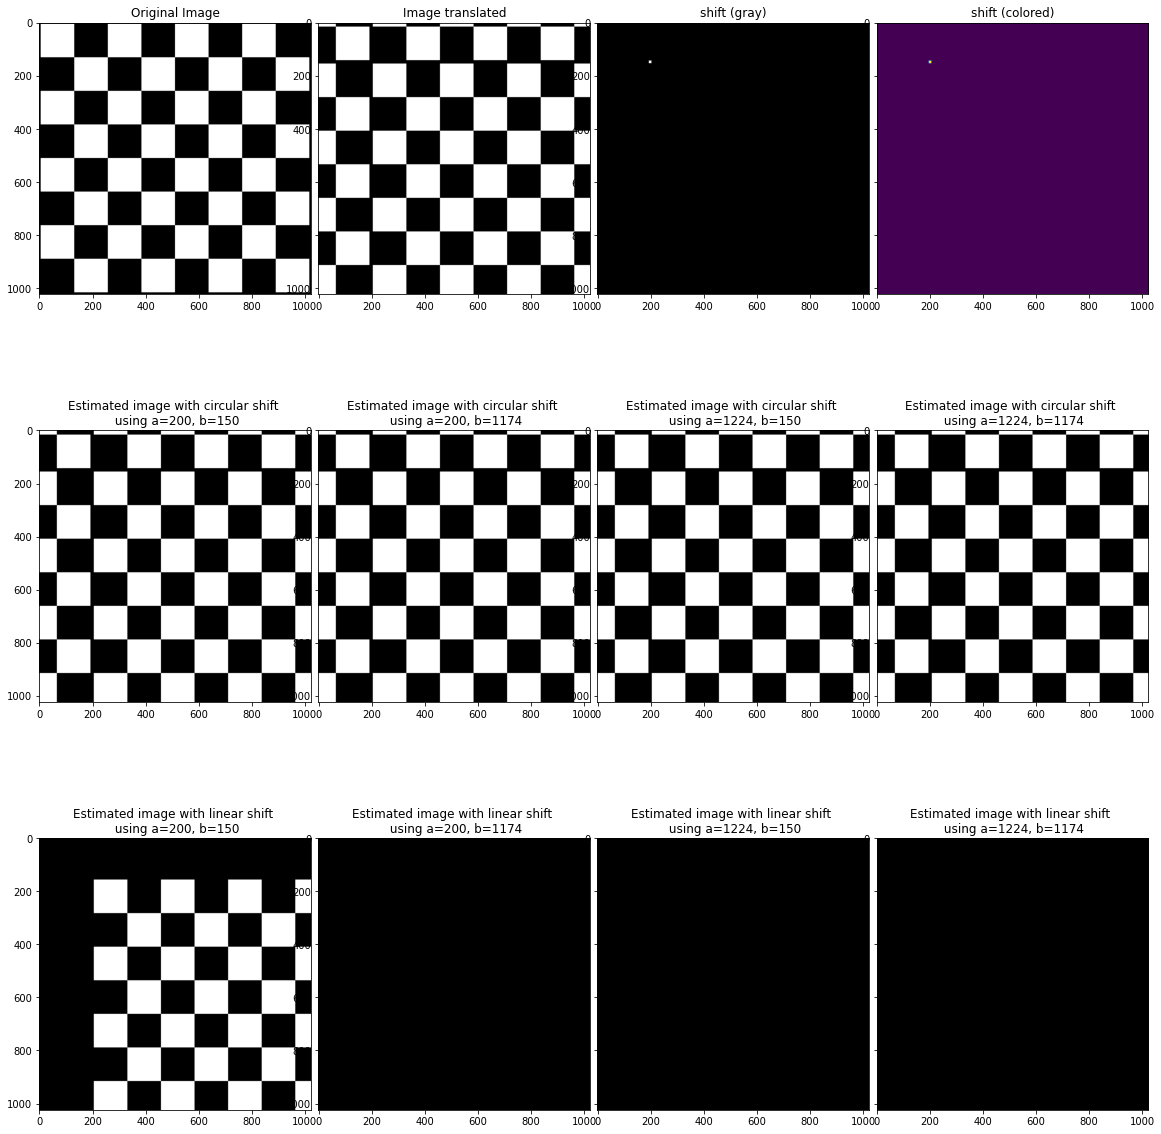

In [21]:
ind, realShift=phaseCorrelation(imgGT, imgG)
if a<0:
  print('Expected a is:', imgG.shape[0]+a, ' using a circular shift this is equivalent to:', a)
else:
  print('Expected a is:', a)  
print('Estimated a is:', ind[1], 'using a circular shift this is equivalent to:', ind[1]-imgG.shape[0])     

if b<0:
  print('Expected b is:', imgG.shape[1]+b, ' using a circular shift this is equivalent to:', b)
else:
  print('Expected b is:', b)  
  print('Estimated b is:', ind[0], 'using a circular shift this is equivalent to:', ind[0]-imgG.shape[1])   

#
# look for the correct image
#

alist = [ind[1], ind[1],ind[1]+imgG.shape[0], ind[1]+imgG.shape[0]] # MODIF
blist = [ind[0], ind[0]+imgG.shape[1], ind[0], ind[0]+imgG.shape[1]] # MODIF
linearImages=[]
linearParam=[]
for a, b in zip(alist, blist):
  linearImages.append((warp(imgG, SimilarityTransform(translation=(-a,-b)) , mode='wrap'), warp(imgG, SimilarityTransform(translation=(-a,-b)) , mode='constant')))
  linearParam.append((a,b))

# Look for the right combination of parameters and for the right warp mode
err=[]
mode='constant'
for k in range(len(linearImages)):
  err.append((((imgGT-linearImages[k][0])**2).sum(),((imgGT-linearImages[k][1])**2).sum()))
err_flat=np.ravel(err)
min_index=np.argmin(err_flat)

if min_index%2==0: # si wrap
  mode='wrap'

print(f'The right combination is : a={alist[min_index//2]}, b={blist[min_index//2]}, mode={mode}')


fig, axs = plt.subplots(3,4, figsize=(20, 20))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs[0].imshow(imgG, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(imgGT , cmap='gray')
axs[1].set_title('Image translated')
# we use a dilation to be able to see the point (an impulse)
axs[2].imshow(dilation(realShift,square(10)), cmap='gray')
axs[2].set_title('shift (gray)')
axs[3].imshow(dilation(realShift,square(10)))
axs[3].set_title('shift (colored)')
k=4
# Plot all possible images with both the wrap mode and the constant mode
for i in range(4):
  axs[k].imshow(warp(imgG, SimilarityTransform(translation=(-alist[i],-blist[i])) , mode='wrap') , cmap='gray')
  axs[k].set_title('Estimated image with circular shift \n using a={0}, b={1}'.format( alist[i],blist[i]))
  k=k+1
for i in range(4):
  axs[k].imshow(warp(imgG, SimilarityTransform(translation=(-alist[i],-blist[i])) , mode='constant') , cmap='gray')
  axs[k].set_title('Estimated image with linear shift \n using a={0}, b={1}'.format( alist[i],blist[i]))
  k=k+1
plt.show() 


# Translation and Gaussian noise image

Please do exactly the same thing as before but using the translated image with noise. 

Question: Does the noise have an impact on the estimate ? If yes, when ?

In [22]:
print("L'ajout d'un bruit gaussien ne modifie pas le résultat")

L'ajout d'un bruit gaussien ne modifie pas le résultat


## Rotation (with respect to the center of the image)

Here, you will look for the rotation angle.
First, let's create a rotated version of the original image with respect to the center of the image. Please be careful to perform the following analyses always with respect to the center of the image.



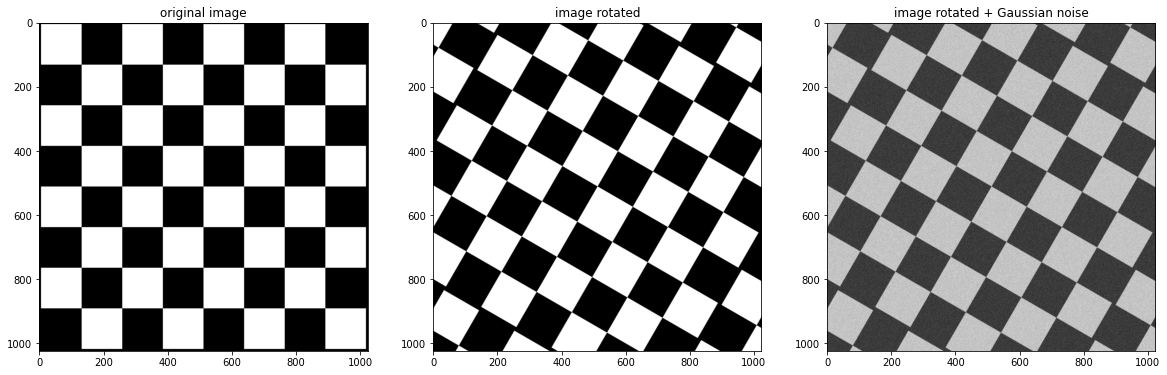

In [23]:
# Let's use only one channel
imgG=np.copy(img[:,:,0])
theta=30 # Rotation angle in clockwise direction as degree.

# simple rotation (minus sign to be consistent with the slides)
tformRotation = SimilarityTransform(rotation=-(math.pi*theta)/180)

# Compute the center of the image
center = np.array((imgG.shape[0], imgG.shape[1])) / 2.
# compute the translation to have the origin at the center of the image
tform1 = SimilarityTransform(translation=-center)
# compute the translation to bring back the origin at the original position
tform3 = SimilarityTransform(translation=center)
# unite transformations, applied in order from left to right
tform = tform1 + tformRotation + tform3

# rotated image. Linear shift mode='constant'. Circular shift mode='wrap'
imgGR = warp(imgG, tform, mode='wrap')
# translated and noise image
imgGRN = imgGR + np.random.normal(0, 0.1, imgGT.shape)

fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(imgG, cmap='gray')
ax1.set_title('original image')
ax2.imshow(imgGR, cmap='gray')
ax2.set_title('image rotated')
ax3.imshow(imgGRN, cmap='gray')
ax3.set_title('image rotated + Gaussian noise')
plt.show() 

As before, we have two ambiguities. One about the angle, which could be $\alpha$ or $\alpha +180$ degrees. And the other one with respect to the shift that has been used to create the rotated image (linear or circular).

Please look for the correct set of parameters (angle and warp mode). First for the rotated image...

Expected angle (degrees) of rotation: 30
Estimated angle (degrees) of rotation: 0 or 180
The right combination is : theta = 30, mode = constant (err value : 27991481194.613194)


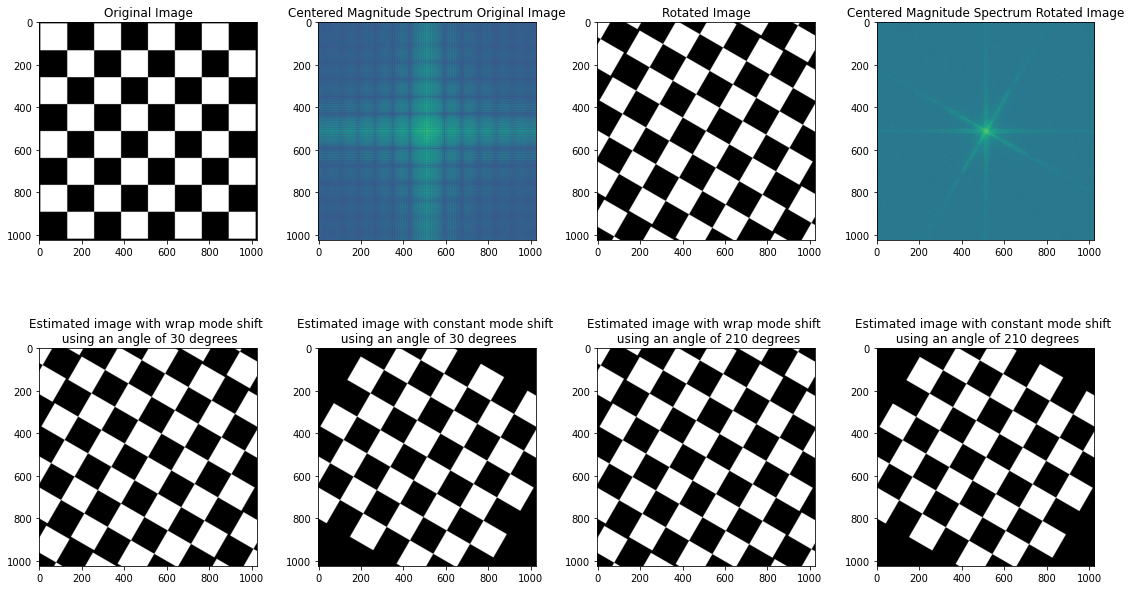

In [24]:
# computation of amplitude/magnitude of original and rotated image
# we also shift the zero-frequency component to the center of the spectrum since we want to have the origin in the middle
# Hint: look at the previously presented 'useful' function...
imgGN=imgG + np.random.normal(0, 0.1, imgGT.shape) # Permet de tester l'effet du bruit blanc 

MimgG = np.abs(np.fft.fftshift(np.fft.fft2(imgGN)))
MimgGR = np.abs(np.fft.fftshift(np.fft.fft2(imgGRN)))

# center is assumed to be the middle of the image
# We will use warp_polar of scikit image but other functions could be used
MimgGP = warp_polar(np.real(MimgG)) 
MimgGRP = warp_polar(MimgGR)

ind, realShift=phaseCorrelation(MimgG, MimgGR)
print('Expected angle (degrees) of rotation:', theta)
print('Estimated angle (degrees) of rotation:',ind[0], 'or', ind[0]+180)

#
# look for the correct image
#
anglelist = [theta, theta, theta+180, theta+180]
modeList=['wrap', 'constant', 'wrap', 'constant']
Images=[]
Param=[]
for t, m in zip(anglelist, modeList):
  Images.append(warp(imgGN,tform1+ SimilarityTransform(rotation=-(math.pi*t)/180) + tform3 , mode=m))
  Param.append((t,m))



# Look for the right combination of parameters and for the right warp mode
err=[]
for k in range(len(Images)):
  err.append(((imgGR-Images[k])**2).sum())
true_img_index=np.argmin(err)

print(f'The right combination is : theta = {anglelist[true_img_index]}, mode = {modeList[true_img_index]} (err value : {err[true_img_index]})')



# Plot images and results
fig, axs = plt.subplots(2,4, figsize=(20, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs[0].imshow(imgG, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(20*np.log(MimgG))
axs[1].set_title('Centered Magnitude Spectrum Original Image')
axs[2].imshow(imgGR, cmap='gray')
axs[2].set_title('Rotated Image')
axs[3].imshow(20*np.log(MimgGR))
axs[3].set_title('Centered Magnitude Spectrum Rotated Image')
k=4
for i in range(len(modeList)):
  axs[k].imshow(warp(imgG,tform1+ SimilarityTransform(rotation=-(math.pi*anglelist[i])/180) + tform3 , mode=modeList[i]) , cmap='gray')
  axs[k].set_title('Estimated image with {0} mode shift \n using an angle of {1} degrees'.format(modeList[i],anglelist[i] ))
  k=k+1
plt.show() 


... and then for the rotated image with Gaussian noise.

Question: Does the white noise have an impact here ? 

In [25]:
print(f'Avec du bruit blanc on ne parvient pas à différencier le mode (wrap ou constant).')

Avec du bruit blanc on ne parvient pas à différencier le mode (wrap ou constant).


**Question**: Answer the previous questions for both images (Paris satellite and chessboard.) Do you notice any difference ? Why in your opinion ?

In [26]:
print(f'Dans le cas des deux images, l\'ajout d\'un bruit empêche de reconnaître le mode dans le cas de la rotation')

Dans le cas des deux images, l'ajout d'un bruit empêche de reconnaître le mode dans le cas de la rotation
